<a href="https://colab.research.google.com/github/FrancescoZanni/MLPNS_FZanni/blob/main/NeuralNetworks/EthicsAIaenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [4]:
cd gdrive/MyDrive/MLPNS_2023


/content/gdrive/MyDrive/MLPNS_2023


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [5]:
!ls

 faces95		   spm
 faces_saved.npy	   spm-20210427T111354Z-001.zip
 higgsClasse		   transformer
 imgreconstruct_10000.h5  'WhatsApp Image 2023-05-02 at 22.46.38 (1).jpeg'
 kaggletitanic		  'WhatsApp Image 2023-05-02 at 22.46.38 (2).jpeg'
 model.png		  'WhatsApp Image 2023-05-02 at 22.46.38.jpeg'


In [6]:
flist = glob.glob("faces95/*/*jpg")

In [7]:
N = len(flist)
N

1441


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

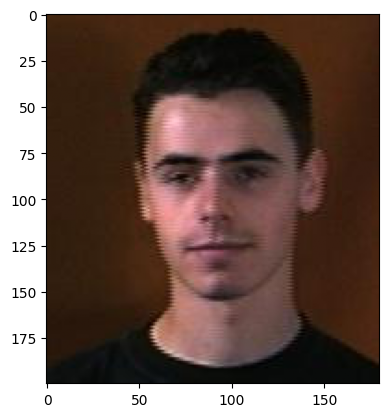

In [8]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

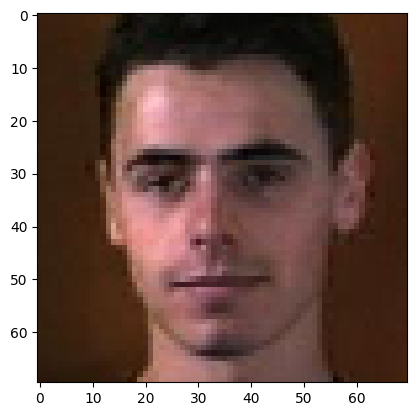

In [9]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [10]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-10-8d7a10a391be>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1441 [00:00<?, ?it/s]

In [11]:
np.save("faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [12]:
imgs = np.load("faces_saved.npy")
imgs.shape

(1441, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [13]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [14]:
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2, 
                        int(imgs.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1441, 35, 35)

In [15]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [16]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [17]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 35, 35), (289, 35, 35), (1152, 70, 70, 1), (289, 70, 70, 1))

In [18]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [19]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 1225), (289, 1225), (1152, 4900), (289, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [20]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1225))
model.add(Dense(128, activation='relu', name="bottleneck"))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(1225*4, activation='sigmoid'))
model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [22]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [23]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
#model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
72/72 [==============================] - 4s 12ms/step - loss: 0.0391 - mae: 0.1553 - acc: 0.0017 - val_loss: 0.0283 - val_mae: 0.1292 - val_acc: 0.0000e+00
Epoch 2/100000
72/72 [==============================] - 0s 7ms/step - loss: 0.0256 - mae: 0.1222 - acc: 0.0000e+00 - val_loss: 0.0205 - val_mae: 0.1086 - val_acc: 0.0000e+00
Epoch 3/100000
72/72 [==============================] - 0s 7ms/step - loss: 0.0198 - mae: 0.1060 - acc: 0.0017 - val_loss: 0.0183 - val_mae: 0.1005 - val_acc: 0.0000e+00
Epoch 4/100000
72/72 [==============================] - 1s 7ms/step - loss: 0.0171 - mae: 0.0973 - acc: 8.6806e-04 - val_loss: 0.0162 - val_mae: 0.0932 - val_acc: 0.0000e+00
Epoch 5/100000
72/72 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0907 - acc: 0.0035 - val_loss: 0.0146 - val_mae: 0.0879 - val_acc: 0.0000e+00
Epoch 6/100000
72/72 [==============================] - 0s 5ms/step - loss: 0.0138 - mae: 0.0856 - acc: 0.0035 - val_loss: 0.0134 - val_mae: 

In [24]:
model.save("imgreconstruct_10000.h5")

In [25]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("imgreconstruct_10000.h5")

## predict

In [26]:
outim = model.predict(X_te)
outim.shape

10/10 [==============================] - 0s 2ms/step


(289, 4900)

In [27]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


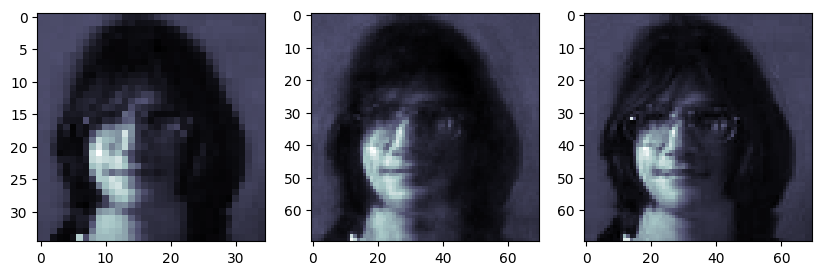

2 :	input		      prediction		  target


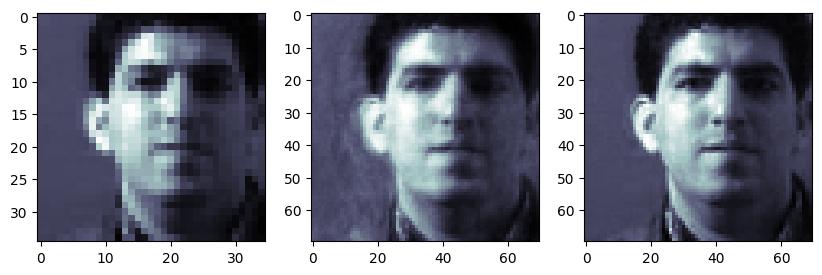

3 :	input		      prediction		  target


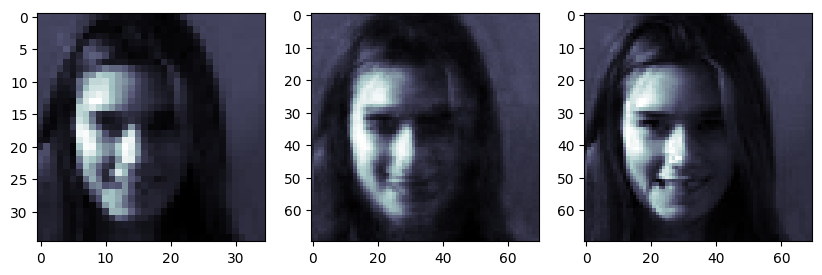

4 :	input		      prediction		  target


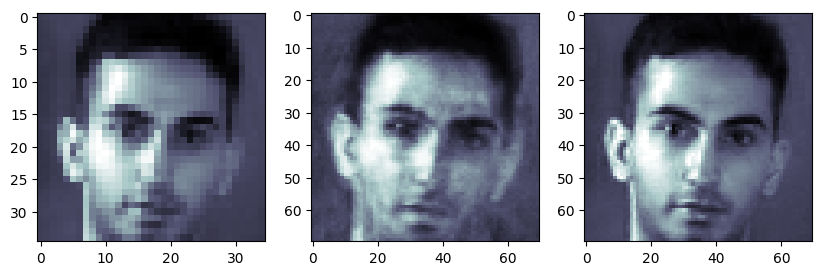

5 :	input		      prediction		  target


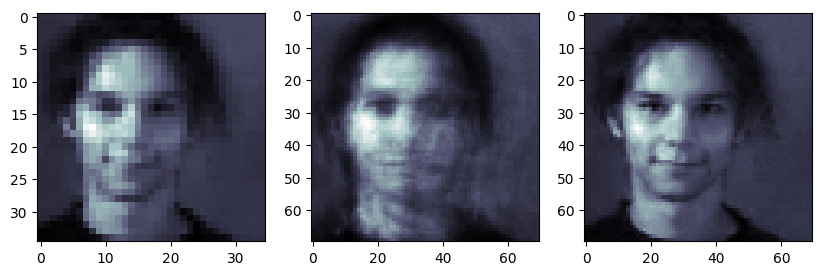

6 :	input		      prediction		  target


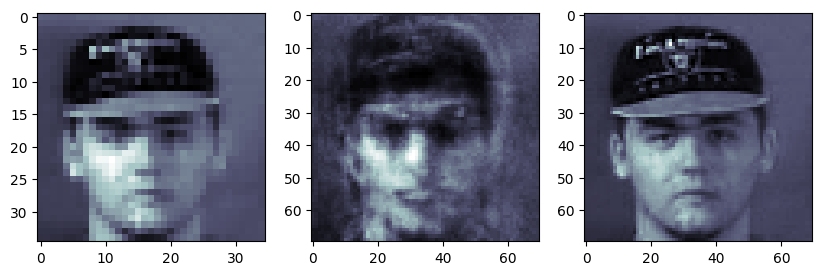

7 :	input		      prediction		  target


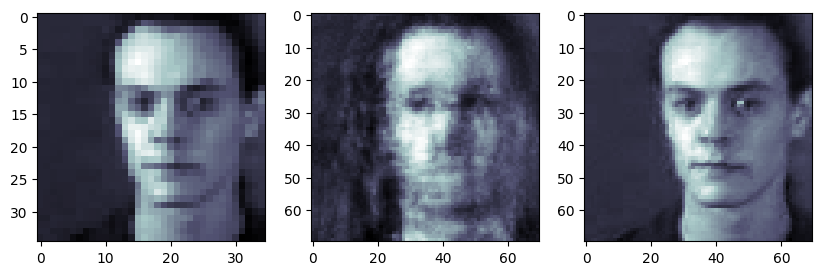

8 :	input		      prediction		  target


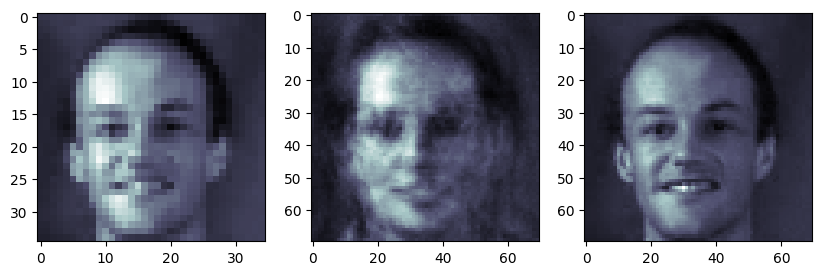

9 :	input		      prediction		  target


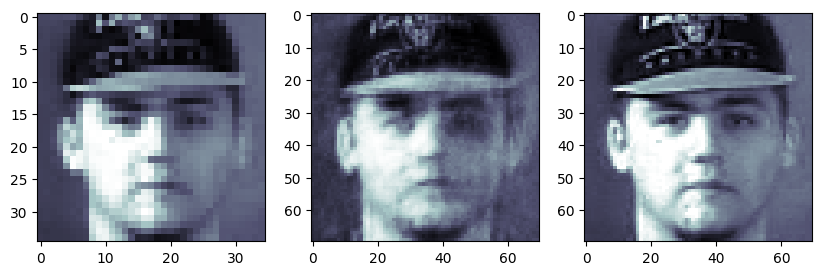

10 :	input		      prediction		  target


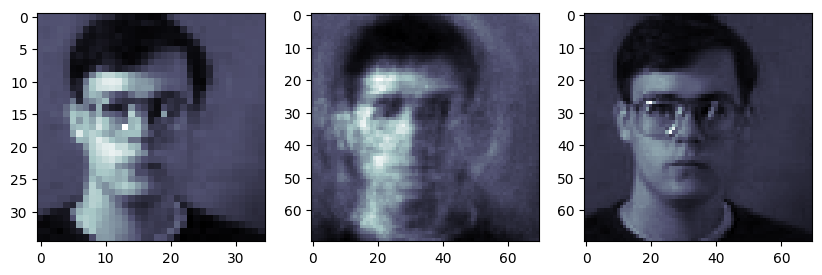

In [28]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?




Come visto in classe la maggio parte delle immagini per le quali l'encoder funziona bene sono immagini di ragazzi maschi, questo perchè rappresentano la categoria maggiormente presente all'interno del dataset. 

Per questo le immagini che invece si prestano peggio all'utilizzo dell'encoder sono quelle di ragazze, la presenza di capelli in particolare sembra dare maggiori problemi. 


## show the latent representation of the data: the bottleneck layer output

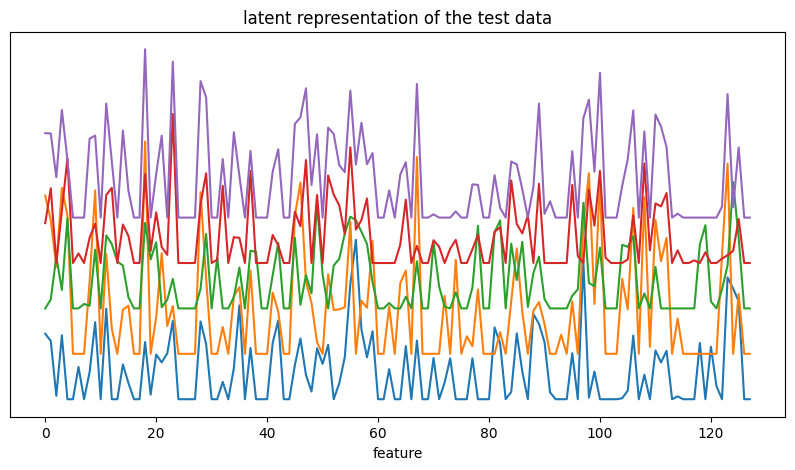

In [29]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[1].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:5])
  
for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

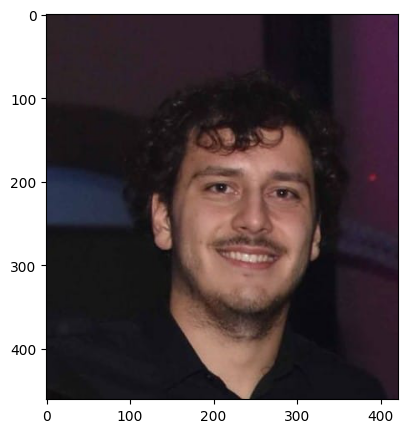

In [31]:
#imme = Image.open(BytesIO(file_contents))
imme = Image.open("WhatsApp Image 2023-05-02 at 22.46.38.jpeg")


pl.imshow(imme);


In [32]:

np_im = np.array(imme)[::2,::2,:3].astype(float) / 255
#pl.imshow(np_im)
#pl.imshow(np_im[20:200,40:200,:] )

imme_original = np.array(np_im)[40:180:2,40:180:2,:1].astype(float) / 255 
imme_lr = np.array(imme_original)[::2,::2,:1].astype(float) / 255 




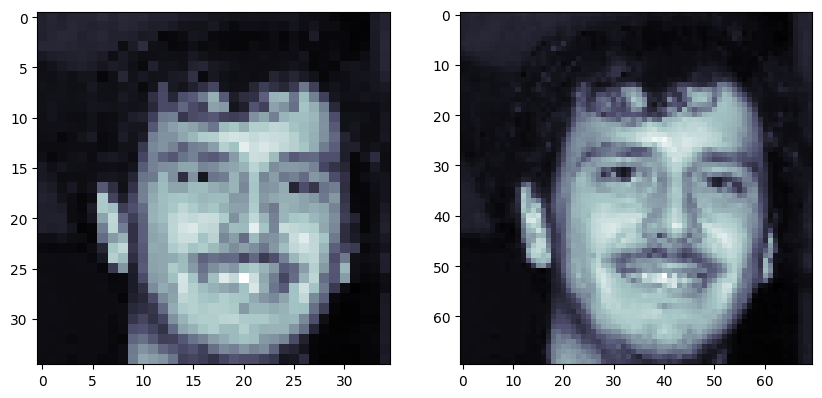

In [34]:

fig = pl.figure(figsize(10,5))
ax = fig.add_subplot(121);
pl.imshow(imme_lr, cmap="bone");
ax = fig.add_subplot(122);
pl.imshow(imme_original, cmap="bone");

low resolution version
subsampling by 15

In [35]:
np_im_me = np_im[100:625,240:775,:][::15,::15,1]
np_im_me.shape


(9, 0)

In [36]:

pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

<ipython-input-36-29a74dd7a667>:1: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.imshow(np_im_me, cmap="bone")


??? celle sopra inutilizzate, 

come fatto prima l'immagine originale è 70x70, quella low resolution passata all'encoder è 35x35, sono ripettivamente "imme_original" e "imme_lr"

1/1 [==============================] - 0s 19ms/step
Input 			 Prediction 			 Target


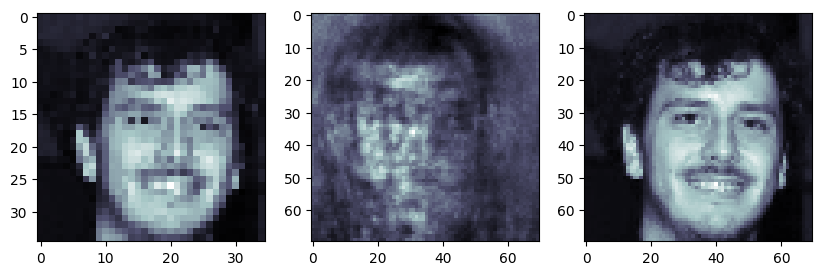

In [37]:
result = model.predict(np.array([imme_lr.flatten()])).reshape(70,70)

print("Input \t\t\t Prediction \t\t\t Target")
fig = pl.figure(figsize(10,5))
ax = fig.add_subplot(131);
pl.imshow(imme_lr, cmap="bone");
ax = fig.add_subplot(132);
pl.imshow(result, cmap="bone");
ax = fig.add_subplot(133); 
pl.imshow(imme_original, cmap="bone");

  


# ... not good at all :-( why??

L'immagine è troppo diversa da quelle presenti nel dataset, che sono state utilizzate per fare il training. 

In particolare ha una sfondo troppo scuro e un' illuminazione del viso troppo chiara, questo fa si che la rete non sia ben allenata per trattare immagini di questo tipo e di conseguenza fornisca una prediction che è completamente fuori strada.

#Modello Convoluzionale


(70, 70, 1)
(35, 35, 1)


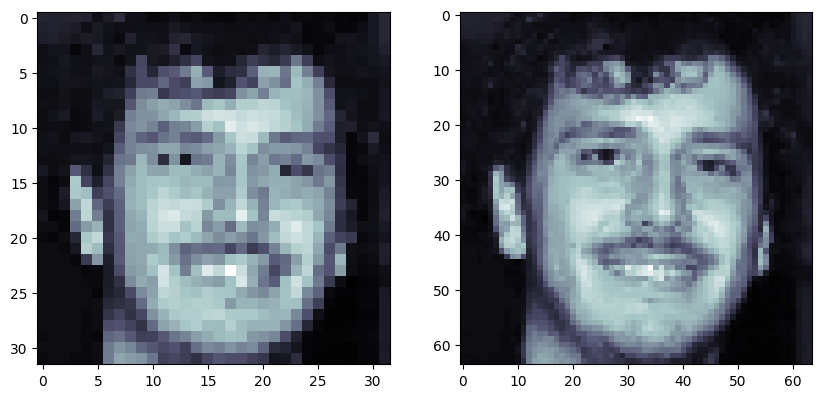

In [40]:
imme_original_64 = imme_original[ 6:, 6:,:]
imme_lr_64 = np.array(imme_original_64)[::2,::2,:1].astype(float) / 255 


print(imme_original.shape)
print(imme_lr.shape)


fig = pl.figure(figsize(10,5))
ax = fig.add_subplot(121);
pl.imshow(imme_lr_64, cmap="bone");
ax = fig.add_subplot(122);
pl.imshow(imme_original_64, cmap="bone");

In [43]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
x=0

# definizione dell'input
input_img = Input(shape=(32, 32, 1)) # immagine in scala di grigi 28x28

# encoding
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) # convoluzione con 16 filtri 3x3
x = MaxPooling2D((2, 2), padding='same')(x) # max pooling con finestra 2x2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # convoluzione con 8 filtri 3x3
x = MaxPooling2D((2, 2), padding='same')(x) # max pooling con finestra 2x2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # convoluzione con 8 filtri 3x3
encoded = MaxPooling2D((2, 2), padding='same', name="bottleneck")(x) # max pooling con finestra 2x2

# decoding

x = UpSampling2D((2, 2))(x) # upsampling con fattore 2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # convoluzione con 8 filtri 3x3
x = UpSampling2D((2, 2))(x) # upsampling con fattore 2
x = Conv2D(16, (3, 3), activation='relu', padding="same")(x) # convoluzione con 16 filtri 3x3
x = UpSampling2D((2, 2))(x) # upsampling con fattore 2
x = Conv2D(32, (3, 3), activation='relu',padding="same")(x) # convoluzione con 16 filtri 3x3
#x = UpSampling2D((2, 2))(x) # upsampling con fattore 2

#decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # convoluzione con 1 filtro 3x3 e funzione di attivazione sigmoide per l'output
# definizione del modello
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adamax', loss='sparse_categorical_crossentropy',
              metrics=['acc'])



In [44]:
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 8)           584 

In [45]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()
imgs_orig = imgs_orig[:, :-6, :-6, :]
print(imgs_orig.shape)
imgs_lr = imgs_orig.reshape(imgs_orig.shape[0], int(imgs_orig.shape[1]/2), 2, 
                        int(imgs_orig.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
print(imgs_lr.shape)



C_tr,  C_te, cy_tr, cy_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)



C_tr.shape, C_te.shape, cy_tr.shape, cy_te.shape

(1441, 64, 64, 1)
(1441, 32, 32)


((1152, 32, 32), (289, 32, 32), (1152, 64, 64, 1), (289, 64, 64, 1))

In [47]:
#tf.config.run_functions_eagerly(True)
callback = EarlyStopping(monitor='loss',
                         patience=10,
                         min_delta=0.0001)

convhistory = autoencoder.fit( C_tr, cy_tr, epochs=100000, 
                    validation_data=[C_te, cy_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])

Epoch 1/100000
72/72 [==============================] - 1s 8ms/step - loss: 0.0543 - acc: 1.8268e-04 - val_loss: 0.0461 - val_acc: 2.6948e-04
Epoch 2/100000
72/72 [==============================] - 1s 8ms/step - loss: 0.0537 - acc: 1.8268e-04 - val_loss: 0.0455 - val_acc: 2.6948e-04
Epoch 3/100000
72/72 [==============================] - 1s 7ms/step - loss: 0.0528 - acc: 1.8268e-04 - val_loss: 0.0446 - val_acc: 2.6948e-04
Epoch 4/100000
72/72 [==============================] - 0s 6ms/step - loss: 0.0513 - acc: 1.8268e-04 - val_loss: 0.0429 - val_acc: 2.6948e-04
Epoch 5/100000
72/72 [==============================] - 0s 6ms/step - loss: 0.0470 - acc: 1.8268e-04 - val_loss: 0.0367 - val_acc: 2.6948e-04
Epoch 6/100000
72/72 [==============================] - 1s 8ms/step - loss: 0.0482 - acc: 1.8268e-04 - val_loss: 0.0437 - val_acc: 2.6948e-04
Epoch 7/100000
72/72 [==============================] - 0s 6ms/step - loss: 0.0492 - acc: 1.8268e-04 - val_loss: 0.0384 - val_acc: 2.6948e-04
Epoch 

In [50]:
result = autoencoder.fit(imme_lr_64)

ValueError: ignored

TypeError: ignored

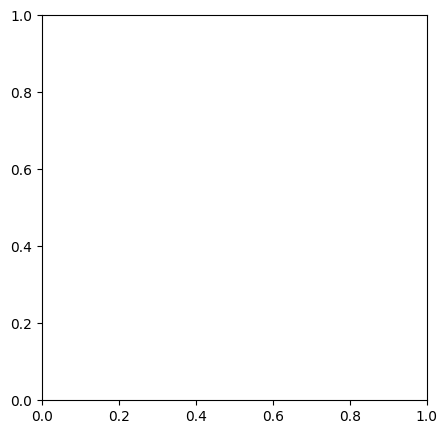

##Problemi di dimensionalità!!